# 1. Import Ntuple

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import uproot
from tqdm.auto import tqdm
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util

training_variables = util.training_variables
columns = util.all_relevant_variables #+ ['__MCDecayString__',]

Welcome to JupyROOT 6.26/14


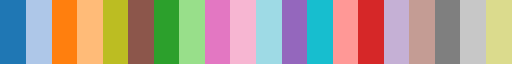

In [2]:
util.my_cmap

In [10]:
# cc = samples_sig['bkg_combinatorial'].query('ell_genMotherPDG * D_genMotherPDG==411*511')
# print(cc['__MCDecayString__'].iloc[4])

Content of MCParticle list
╰── Upsilon(4S) (300553)
    ├── B0 (511)
    │   ├── D- (-411)
    │   │   ├── K0 (311)
    │   │   │   ╰── K_L0 (130)
    │   │   │       ├╶╶ pi- (-211)
    │   │   │       ├╶╶ pi+ (211)
    │   │   │       │   ├╶╶ nu_mu (14)
    │   │   │       │   ├╶╶ mu+ (-13)
    │   │   │       │   │   ├╶╶ anti-nu_mu (-14)
    │   │   │       │   │   ├╶╶ nu_e (12)
    │   │   │       │   │   ╰╶╶ e+ (-11)
    │   │   │       │   ╰╶╶ e- (11)
    │   │   │       ╰╶╶ n0 (2112)
    │   │   ├── e- (11)
    │   │   │   ╰╶╶ gamma (22)
    │   │   ├── anti-nu_e (-12)
    │   │   ╰── gamma (22)
    │   ├── pi+ (211)
    │   │   ├╶╶ nu_mu (14)
    │   │   ╰╶╶ mu+ (-13)
    │   │       ├╶╶ anti-nu_mu (-14)
    │   │       ├╶╶ nu_e (12)
    │   │       ╰╶╶ e+ (-11)
    │   ├── rho+ (213)
    │   │   ├── pi+ (211)
    │   │   │   ╰╶╶ pi- (-211)
    │   │   ╰── pi0 (111)
    │   │       ├── gamma (22)
    │   │       ╰── gamma (22)
    │   │           ╰╶╶ gamma (22)
    │   ├── eta (

In [2]:
# 4S wrong charge Data vs MC, and MC wc vs cc

cut = '(5<B0_roeMbc_my_mask) & (-4<B0_roeDeltae_my_mask) & (B0_roeDeltae_my_mask<1)'

# Load data files
MC_cc = uproot.concatenate([f'../../Samples/MC15ri/e_channel/1ab_quaxo_4/*ed.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

MC_wc = uproot.concatenate([f'../../Samples/MC15ri/e_channel/local_wrongCharge_200fb/*.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

data_wc = uproot.concatenate([f'../../Samples/Data/e_channel/proc13_4S_wc_quaxo_2.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

df_mc_cc = pd.DataFrame(MC_cc)
df_mc_wc = pd.DataFrame(MC_wc)
df_data_wc = pd.DataFrame(data_wc)

In [3]:
lgb_tight = 'sig_prob==largest_prob and sig_prob>0.6 and fakeD_prob<0.05'
ag_tight = 'sig_prob==largest_prob and sig_prob>0.8 and fakeD_prob<0.05'
MVA_all = 'sig_prob>0'

In [4]:
for df in [df_mc_cc, df_mc_wc, df_data_wc,]:
    # df.eval(f'cos_D_l = (D_px*ell_px + D_py*ell_py + D_pz*ell_pz)/(D_p*ell_p)', inplace=True)
    df.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
    df.eval(f'p_D_l = D_CMS_p + ell_CMS_p', inplace=True)

In [5]:
# lgb + BCS
df_mc_cc_lgb = util.apply_mva_bcs(df_mc_cc, training_variables, lgb_tight, library='lgbm')
df_mc_wc_lgb = util.apply_mva_bcs(df_mc_wc, training_variables, lgb_tight, library='lgbm')
df_data_wc_lgb = util.apply_mva_bcs(df_data_wc, training_variables, lgb_tight, library='lgbm')

In [6]:
samples_control=util.classify_mc_dict(df_mc_wc_lgb, 'e', template=False)
samples_sig = util.classify_mc_dict(df_mc_cc_lgb, 'e', template=False)

mpl=util.mpl(samples_control,df_data_wc_lgb)
for name, df in samples_control.items():
    print(name, len(df))

bkg_fakeD 3475
bkg_TDFl 614
bkg_fakeTracks 94
bkg_continuum 95
bkg_combinatorial 4996
bkg_singleBbkg 105
bkg_other_TDTl 0
$D\tau\nu$ 0
$D^\ast\tau\nu$ 0
$D\ell\nu$ 0
$D^\ast\ell\nu$ 0
$D^{\ast\ast}\tau\nu$ 0
$D^{\ast\ast}\ell\nu$_narrow 0
$D^{\ast\ast}\ell\nu$_broad 0
$D\ell\nu$_gap_pi 0
$D\ell\nu$_gap_eta 0
bkg_other_signal 0


In [7]:
comb_wc = util.classify_combinatorial(samples_control['bkg_combinatorial'])

samples_wc = samples_control.copy()
samples_wc.update({'bkg_combinatorial': pd.DataFrame(columns=columns)})
samples_wc.update(comb_wc)

In [8]:
mpl_wc=util.mpl(samples_wc, df_data_wc_lgb)
for name, df in samples_wc.items():
    print(name, len(df))

bkg_fakeD 3475
bkg_TDFl 614
bkg_fakeTracks 94
bkg_continuum 95
bkg_combinatorial 0
bkg_singleBbkg 105
bkg_other_TDTl 0
$D\tau\nu$ 0
$D^\ast\tau\nu$ 0
$D\ell\nu$ 0
$D^\ast\ell\nu$ 0
$D^{\ast\ast}\tau\nu$ 0
$D^{\ast\ast}\ell\nu$_narrow 0
$D^{\ast\ast}\ell\nu$_broad 0
$D\ell\nu$_gap_pi 0
$D\ell\nu$_gap_eta 0
bkg_other_signal 0
DSemiB_ellPri 479
DSemiB_ellSec 189
DHad1Charm_ellPri 2747
DHad1Charm_ellSec 453
DHad2Charm_ellPri 815
DHad2Charm_ellSec 309
others 4


# Check WC vs. CC

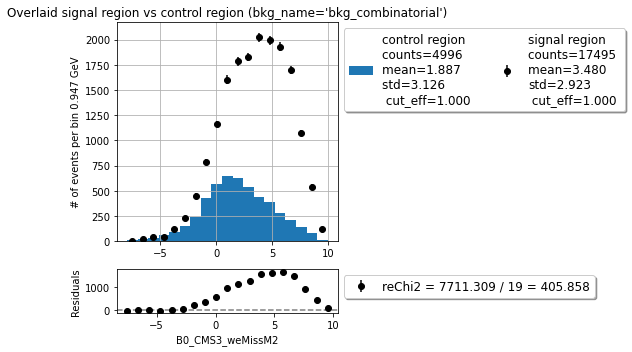

In [11]:
# compare control vs signal regions MC
b1 = np.linspace(-8,10,20)
scale = {'control region': 1,
         'signal region': 0.02}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_combinatorial',
                        cut=None,
                        samples_sig=samples_sig,
                        scale=scale,correction=False,mask=[])

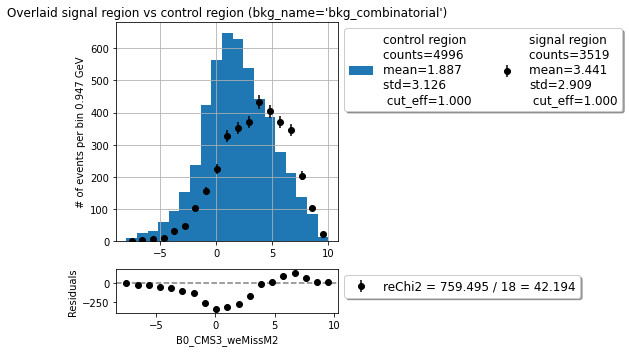

In [18]:
# compare control vs signal regions MC
b1 = np.linspace(-8,10,20)
scale = {'control region': 1,
         'signal region': 1}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_combinatorial',
                        cut=None,
                        samples_sig=samples_sig,
                        scale=scale,correction=False,mask=[])

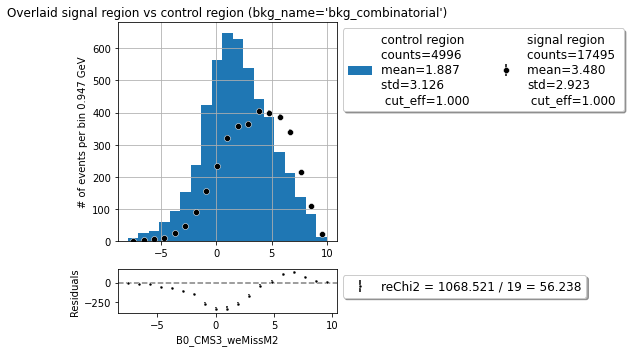

In [22]:
# compare control vs signal regions MC
b1 = np.linspace(-8,10,20)
scale = {'control region': 1,
         'signal region': 0.2}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_combinatorial',
                        cut=None,
                        samples_sig=samples_sig,
                        scale=scale,correction=False,mask=[])

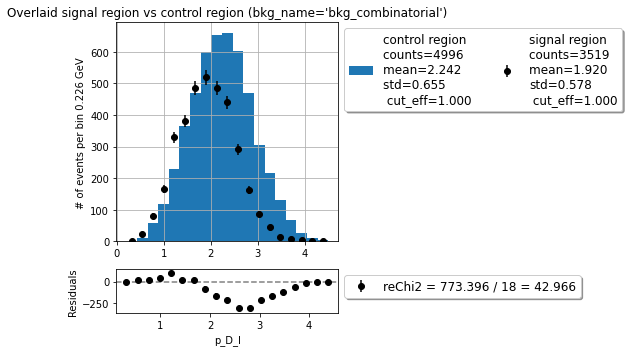

In [20]:
b2 = np.linspace(0.2,4.5,20)
scale = {'control region': 1,
         'signal region': 1}
mpl.plot_mc_sig_control(variable='p_D_l',bins=b2,
                        bkg_name='bkg_combinatorial',cut=None,
                        samples_sig=samples_sig,
                        scale=scale,correction=False,mask=[])

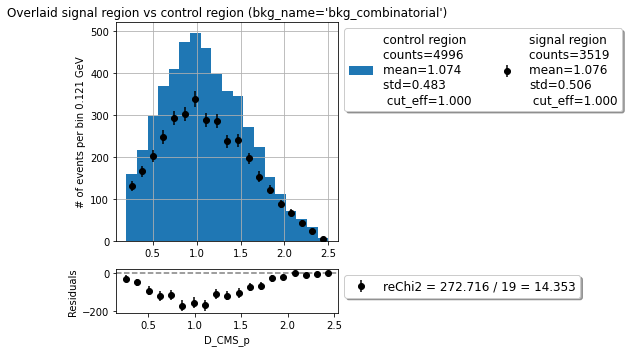

In [11]:
b2 = np.linspace(0.2,2.5,20)
scale = {'control region': 1,
         'signal region': 1}
mpl.plot_mc_sig_control(variable='D_CMS_p',bins=b2,
                        bkg_name='bkg_combinatorial',cut=None,
                        samples_sig=samples_sig,
                        scale=scale,correction=False,mask=[])

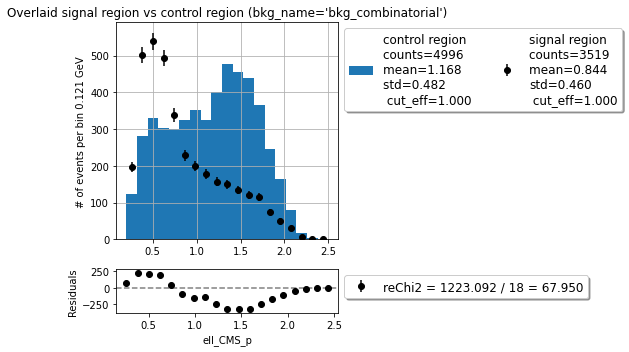

In [12]:
b2 = np.linspace(0.2,2.5,20)
scale = {'control region': 1,
         'signal region': 1}
mpl.plot_mc_sig_control(variable='ell_CMS_p',bins=b2,
                        bkg_name='bkg_combinatorial',cut=None,
                        samples_sig=samples_sig,
                        scale=scale,correction=False,mask=[])

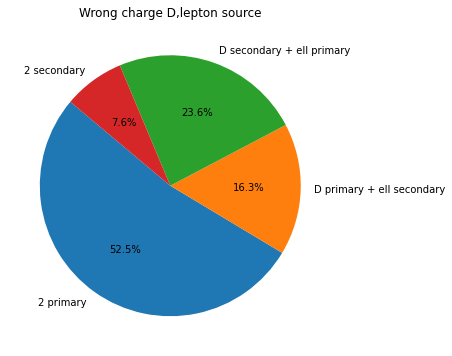

In [20]:
# Example data
sizes = [2545, 791, 1144, 367]  # Portion sizes for each component
labels = ['2 primary', 'D primary + ell secondary', 
          'D secondary + ell primary','2 secondary']  # Names of each component

# Plotting the pie chart
plt.figure(figsize=(8, 6))  # Optional: adjust the size of the figure
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Wrong charge D,lepton source')
plt.show()

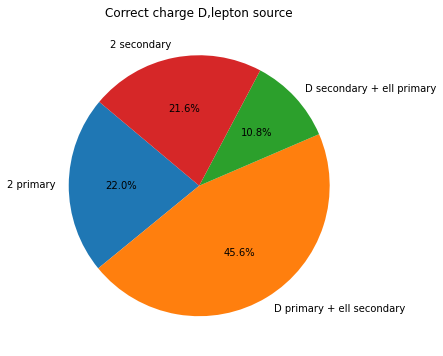

In [25]:
# Example data
sizes = [733, 1516, 359, 720]  # Portion sizes for each component
labels = ['2 primary', 'D primary + ell secondary', 
          'D secondary + ell primary','2 secondary']  # Names of each component

# Plotting the pie chart
plt.figure(figsize=(8, 6))  # Optional: adjust the size of the figure
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Correct charge D,lepton source')
plt.show()

### Conclusion: Cannot use data driven for combinatorial bkg, WC and CC have different physics
#### Consider using MC template CC

# Check Data vs. MC

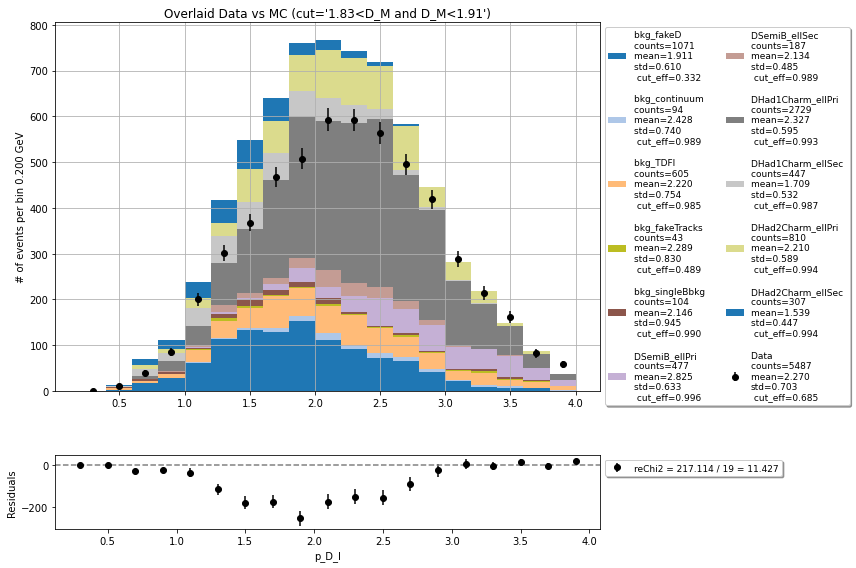

In [41]:
b2 = np.linspace(0.2,4,20)
a,b=mpl_wc.plot_data_mc_stacked(variable='p_D_l',bins=b2,ratio=False,
                          cut='1.83<D_M and D_M<1.91',
                          correction=False,mask=[],figsize=(12,8),
                          legend_nc=2,legend_fs=9,weights={
                              'DSemiB_ellPri':    1,
                              'DSemiB_ellSec':    1,
                              'DHad1Charm_ellPri':1,
                              'DHad1Charm_ellSec':1,
                              'DHad2Charm_ellPri':1,
                              'DHad2Charm_ellSec':1})

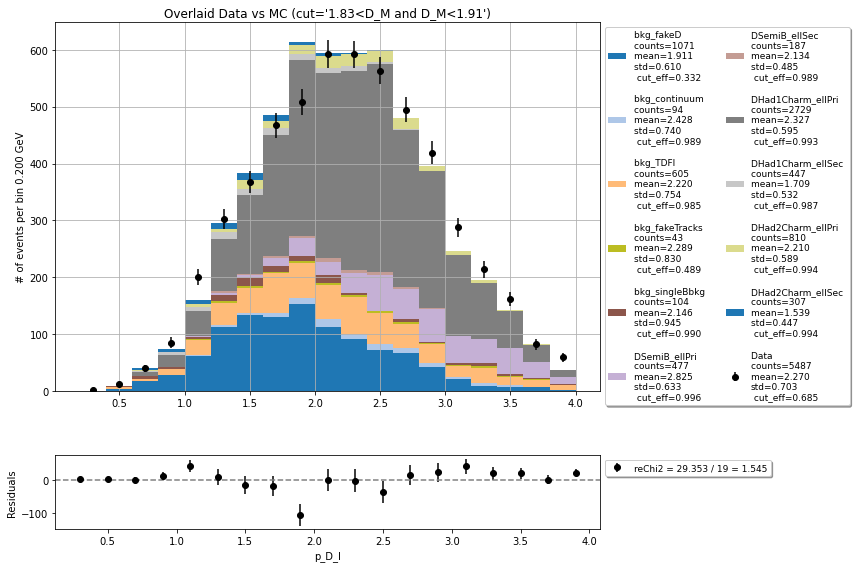

In [38]:
b2 = np.linspace(0.2,4,20)
a,b=mpl_wc.plot_data_mc_stacked(variable='p_D_l',bins=b2,ratio=False,
                          cut='1.83<D_M and D_M<1.91',
                          correction=False,mask=[],figsize=(12,8),
                          legend_nc=2,legend_fs=9,weights={
                              'DSemiB_ellPri':    1,
                              'DSemiB_ellSec':    0.2,
                              'DHad1Charm_ellPri':1,
                              'DHad1Charm_ellSec':0.2,
                              'DHad2Charm_ellPri':0.2,
                              'DHad2Charm_ellSec':0.2})

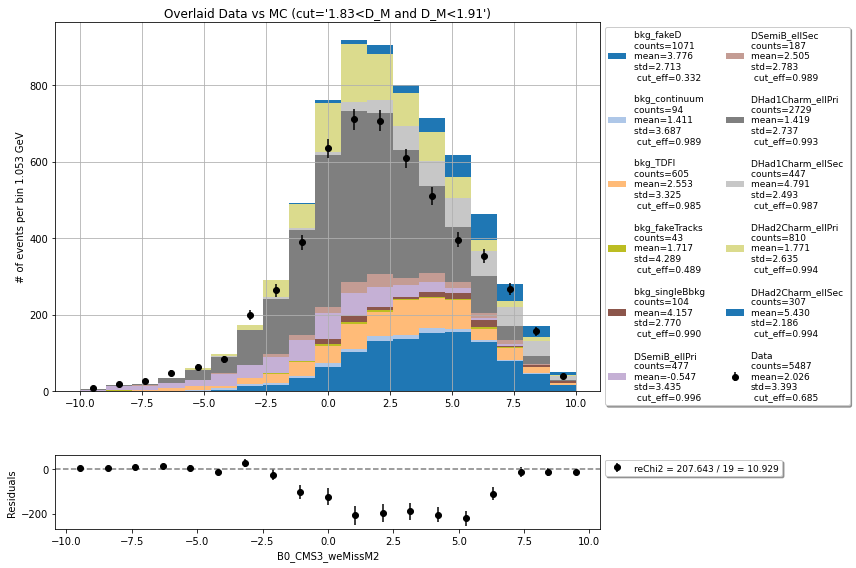

In [40]:
b1 = np.linspace(-10,10,20)
a,b=mpl_wc.plot_data_mc_stacked(variable='B0_CMS3_weMissM2',bins=b1,ratio=False,
                          cut='1.83<D_M and D_M<1.91',
                          correction=False,mask=[],figsize=(12,8),
                          legend_nc=2,legend_fs=9,weights={
                              'DSemiB_ellPri':    1,
                              'DSemiB_ellSec':    1,
                              'DHad1Charm_ellPri':1,
                              'DHad1Charm_ellSec':1,
                              'DHad2Charm_ellPri':1,
                              'DHad2Charm_ellSec':1})

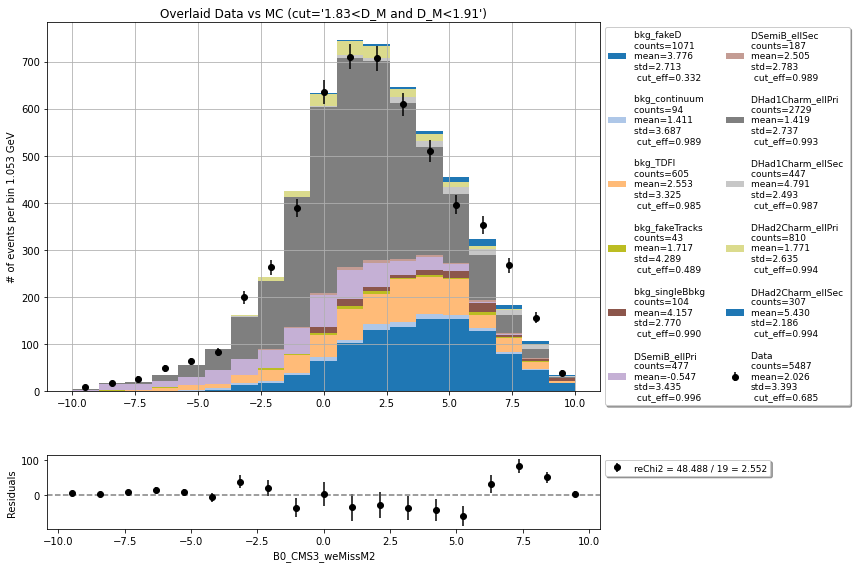

In [39]:
b1 = np.linspace(-10,10,20)
a,b=mpl_wc.plot_data_mc_stacked(variable='B0_CMS3_weMissM2',bins=b1,ratio=False,
                          cut='1.83<D_M and D_M<1.91',
                          correction=False,mask=[],figsize=(12,8),
                          legend_nc=2,legend_fs=9,weights={
                              'DSemiB_ellPri':    1,
                              'DSemiB_ellSec':    0.2,
                              'DHad1Charm_ellPri':1,
                              'DHad1Charm_ellSec':0.2,
                              'DHad2Charm_ellPri':0.2,
                              'DHad2Charm_ellSec':0.2})

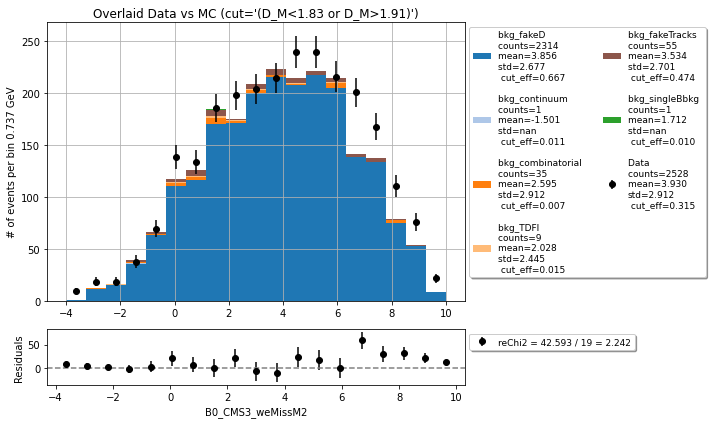

In [28]:
# sidebands
b1 = np.linspace(-4,10,20)
a,b=mpl.plot_data_mc_stacked(variable='B0_CMS3_weMissM2',bins=b1,figsize=(10,6),
                          cut='(D_M<1.83 or D_M>1.91)',
                          scale=[1,187/200],correction=False,
                          mask=[],ratio=False,legend_fs=9)

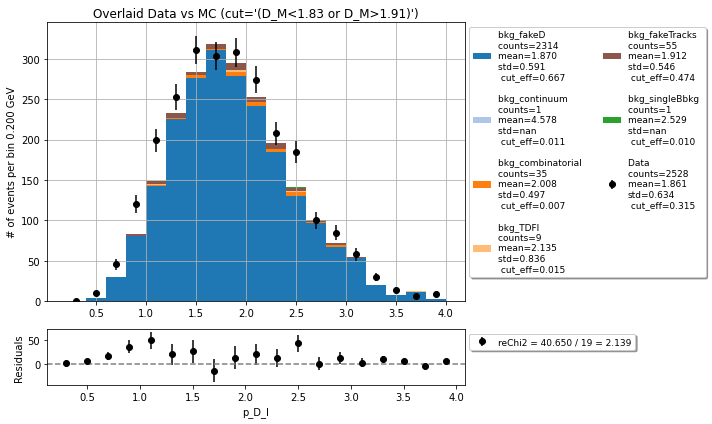

In [34]:
# sidebands
b2 = np.linspace(0.2,4,20)
a,b=mpl.plot_data_mc_stacked(variable='p_D_l',bins=b2,ratio=False,
                          cut='(D_M<1.83 or D_M>1.91)',legend_fs=9,
                          scale=[1,187/200],correction=False,mask=[],figsize=(10,6))

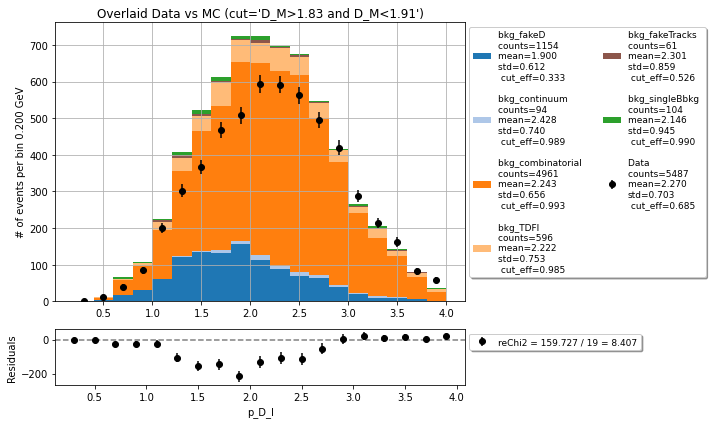

In [37]:
# signal
b2 = np.linspace(0.2,4,20)
a,b=mpl.plot_data_mc_stacked(variable='p_D_l',bins=b2,ratio=False,
                          cut='1.83<D_M and D_M<1.91',scale=[1,187/200],
                             correction=False,mask=[],figsize=(10,6),
                            legend_fs=9)

# Create data driven template for FakeD
## 1. Calculate the sidebands to sig region scaling factors
### a. Histogram the D_M distribution

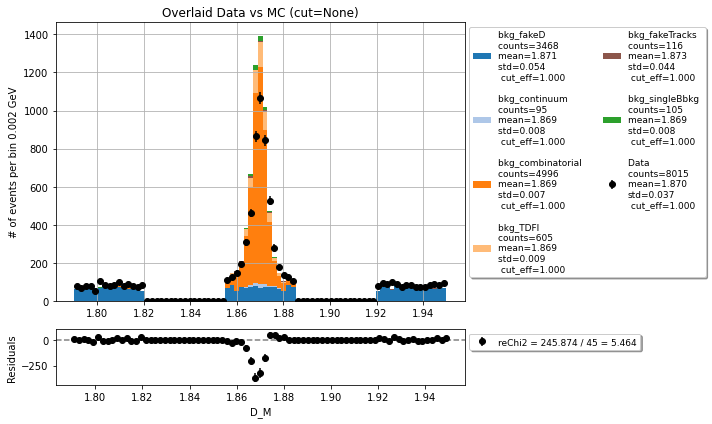

In [41]:
# showing the fake D and sidebands in D_M
b1 = np.linspace(1.79,1.95,80)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='D_M',bins=b1,cut=None,scale=[1,187/200],
    correction=False,mask=[],figsize=(10,6),ratio=False,legend_fs=9)

### b. fit the FakeD with a polynomial

In [45]:
fitter = util.fit_iminuit(x_edges=b1, hist=data_hist_all, poly_only=True)

In [46]:
m_ls, c_ls, result_ls = fitter.fit_gauss_poly_LS(deg=1, loss='linear') #'soft_l1'
m_ls

initial parameters= [1.60e+00 1.87e+00 4.00e-02 2.22e+01 5.99e+01]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 40.43 (chi2/ndof = 1.5)    │              Nfcn = 70               │
│ EDM = 6.14e-20 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.000   │   0.016   │            │            │    0    │         │  yes  │
│ 1 │ x1   │   1.870   │   0.019   │            │            │    0    │         │  yes  │
│ 2 │ x2   │  40.0e-3  │  0.4e-3   │            │            │    0    │         │  yes  │
│ 3 │ x3   │    40     │    26     │            │            │         │         │       │
│ 4 │ x4   │    10     │    50     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4 │
├────┼───────────────────────────────────────────────────┤
│ x0 │         0         0         0         0         0 │
│ x1 │         0         0         0         0         0 │
│ x2 │         0         0         0         0         0 │
│ x3 │         0         0         0       654 -1.22e+03 │
│ x4 │         0         0         0 -1.22e+03  2.29e+03 │
└────┴───────────────────────────────────────────────────┘

In [47]:
m_ml, c_ml, result_ml = fitter.fit_gauss_poly_ML(deg=1)
m_ml

initial parameters= [8.015e+02 1.870e+00 4.000e-02 8.015e+03 2.220e+01 6.000e+01]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 37.6 (chi2/ndof = 1.5)     │              Nfcn = 98               │
│ EDM = 3.7e-07 (Goal: 0.0002)     │            time = 0.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │     0     │     8     │            │            │    0    │         │  yes  │
│ 1 │ x1   │   1.870   │   0.019   │            │            │    0    │         │  yes  │
│ 2 │ x2   │  40.0e-3  │  0.4e-3   │            │            │    0    │         │  yes  │
│ 3 │ x3   │  6.67e3   │  0.14e3   │            │            │         │         │       │
│ 4 │ x4   │     0     │   0.6e3   │            │            │         │         │       │
│ 5 │ x5   │  0.01e3   │  0.30e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────────┐
│    │       x0       x1       x2       x3       x4       x5 │
├────┼───────────────────────────────────────────────────────┤
│ x0 │        0        0        0        0        0        0 │
│ x1 │        0        0        0        0        0        0 │
│ x2 │        0        0        0        0        0        0 │
│ x3 │        0        0        0 1.88e+04  -0.0127 -0.00677 │
│ x4 │        0        0        0  -0.0127 3.23e+05 1.68e+05 │
│ x5 │        0        0        0 -0.00677 1.68e+05  8.9e+04 │
└────┴───────────────────────────────────────────────────────┘

### c. Calculate the yield ratio

In [ ]:
area_left,error_left = fitter.poly_integral(xrange=[1.79,1.82],result=result_ls)
area_sig, error_sig = fitter.poly_integral(xrange=[1.855,1.885],result=result_ls)
area_right,error_right = fitter.poly_integral(xrange=[1.92,1.95],result=result_ls)

In [48]:
yields_left = fitter.poly_integral(xrange=[1.79,1.82],result=result_ml)
yields_sig = fitter.poly_integral(xrange=[1.855,1.885],result=result_ml)
yields_right = fitter.poly_integral(xrange=[1.92,1.95],result=result_ml)

Yields from 1.79 to 1.82: 1217.17
Yields from 1.855 to 1.885: 1251.116
Yields from 1.92 to 1.95: 1285.063


In [49]:
a = len(samples_control['bkg_fakeD'].query('1.79<D_M<1.82')) * 187/200
b = len(samples_control['bkg_fakeD'].query('1.92<D_M<1.95')) * 187/200
print('truth',a,b, a/b)

truth 1068.705 1094.885 0.9760888129803587


### d. Plot and compare MC of the weighted sideband and signal region

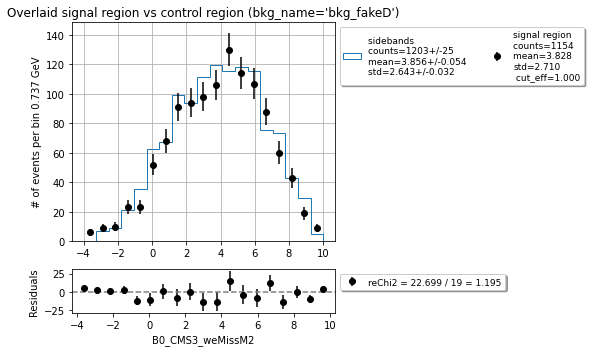

In [50]:
# showing the scaled sidebands vs. sig region from mc
b1 = np.linspace(-4,10,20)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_fakeD',cut=None,merge_sidebands=True,
                        scale=scale,correction=False,mask=[],legend_fs=9)

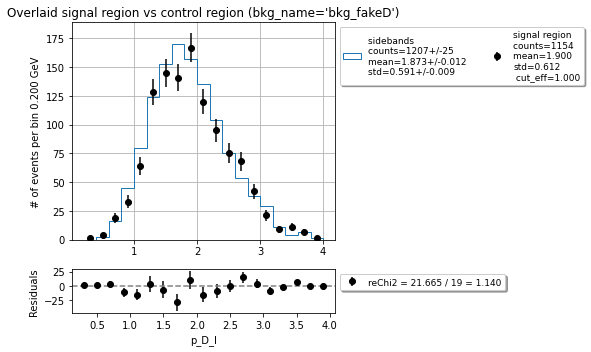

In [51]:
b2 = np.linspace(0.2,4,20)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable='p_D_l',bins=b2,merge_sidebands=True,
                        bkg_name='bkg_fakeD',cut=None,
                        scale=scale,correction=False,mask=[],legend_fs=9)

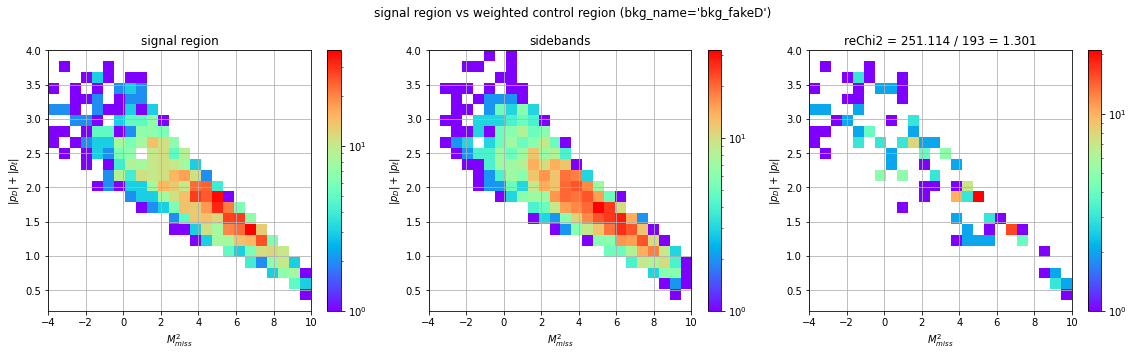

In [52]:
b1 = np.linspace(-4,10,25)
b2 = np.linspace(0.2,4,25)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable=['B0_CMS3_weMissM2','p_D_l'],
                        bins=[b1,b2],
                        bkg_name='bkg_fakeD',cut=None,merge_sidebands=True,
                        scale=scale,correction=True,mask=[],figsize=(16,5))

## 2. Subtract the FakeD from the signal region

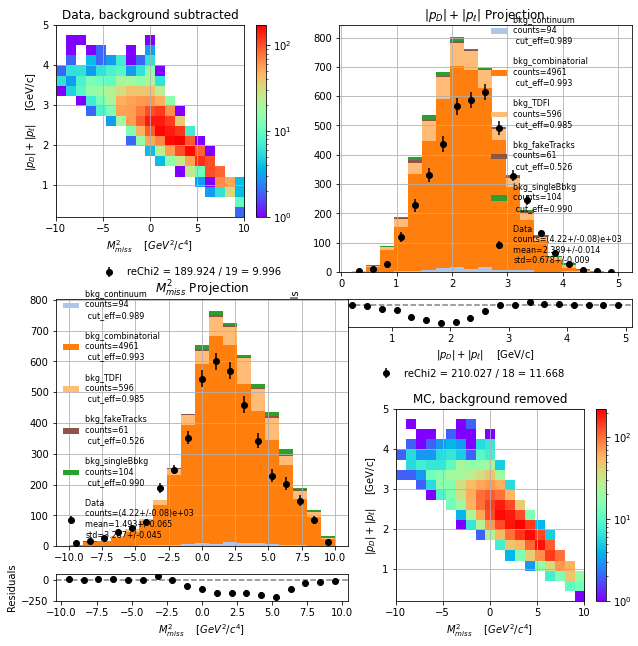

In [53]:
# BDT signal
b_mm2 = np.linspace(-10,10,20)
b_pDl = np.linspace(0.2,5,20)
scale = {'data left sideband': yields_sig/yields_left/2,
         'data signal region': 1,
         'data right sideband': yields_sig/yields_right/2,
         'mc signal region': 187/200}
par_dict={'var_list':['B0_CMS3_weMissM2','p_D_l'],
          'bin_list': [b_mm2, b_pDl],
          'cut': None, #'B0_roeMbc_my_mask>5.1 and -4<B0_roeDeltae_my_mask<1',
          'scale': scale,
          'correction': False,
          'mask': ['bkg_fakeD']}
mpl.plot_data_subtracted_and_mc(**par_dict)

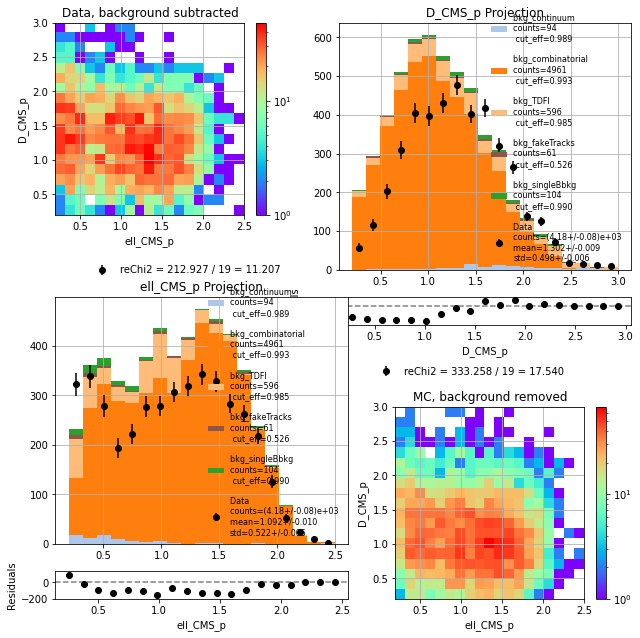

In [55]:
# BDT signal, pl; pd
b_mm2 = np.linspace(0.2,2.5,20)
b_pDl = np.linspace(0.2,3,20)
scale = {'data left sideband': yields_sig/yields_left/2,
         'data signal region': 1,
         'data right sideband': yields_sig/yields_right/2,
         'mc signal region': 187/200}
par_dict={'var_list':['ell_CMS_p','D_CMS_p'],
          'bin_list': [b_mm2, b_pDl],
          'cut': None,
          'scale': scale,
          'correction': False,
          'mask': ['bkg_fakeD']}
mpl.plot_data_subtracted_and_mc(**par_dict)

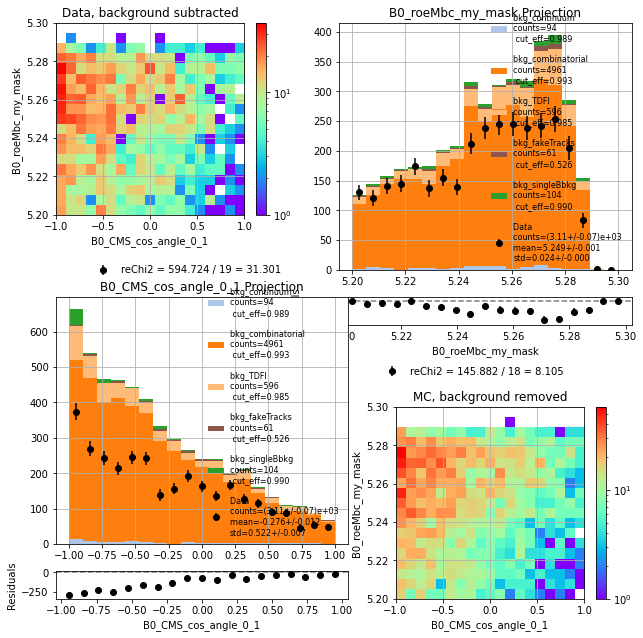

In [59]:
# BDT signal, pl; pd
b_mm2 = np.linspace(-1,1,20)
b_pDl = np.linspace(5.2,5.3,20)
scale = {'data left sideband': yields_sig/yields_left/2,
         'data signal region': 1,
         'data right sideband': yields_sig/yields_right/2,
         'mc signal region': 187/200}
par_dict={'var_list':['B0_CMS_cos_angle_0_1','B0_roeMbc_my_mask'],
          'bin_list': [b_mm2, b_pDl],
          'cut': 'B0_roeMbc_my_mask>5.2',
          'scale': scale,
          'correction': False,
          'mask': ['bkg_fakeD']}
mpl.plot_data_subtracted_and_mc(**par_dict)